# BACKGROUND

### In this project, I developed a self-driving program for the videogame GTA 5 using a recurrent LSTM model. It was based off of statistical Physics concepts which I had learned while doing my degree at the University of Toronto not long before.

### In this notebook, we perform feature engineering and selection of user timeseries data, and use data augmentation via Gaussian noise to provide regularization. It turns out that this worked out better than I had expected.


# Taking a Page out of Physics

### During Feature Selection, a very interesting result arose.
### Initially, there wasn't a lot of timeseries data to train the model on, so data augmentation was applied by generating multiple versions of the keystroke data and then adding Gaussian noise. The results were improved predictive accuracy on training and validation datasets. 
### It seems that the driving process itself appears to follow a pattern similar to Geometric Brownian Motion, a concept in physics used to model the motion of particles travelling randomly through a fluid, e.g. the path that a speck of dust takes in mid-air.



In [1]:
import os 
# from nsepy import get_history as gh
import datetime as dt
from datetime import date
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d  
from IPython.display import clear_output
import warnings
import numpy as np
import pandas as pd
#Data Preprocessing
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
#Time Series Machine Learning Based
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout  
from keras.models import Sequential 
import tensorflow as tf
#Discrete
import random

# One dimensional Model

### We'll build a 1D model as proof of concept that Recurrent LSTM's trained with Gaussian noise produce incredibly accurate time series predictions, based on the fact that they approximate geometric Brownian motion just off of their stochastic nature.

### In the next section, we add 2D depth to account for the fact that in self-driving, we have (1)forward and backwards data, and (2) right and left turning. 
### Treating these as two separate input data vectors and adding 2 neurons in the output layer of the model should enable us to make decisions about motion in a 2D space.

In [3]:
fwd = np.zeros(1000) + 1
bwd = np.zeros(300) - 3.1
data =  fwd.tolist() + bwd.tolist()
random.shuffle(data)
len(data) 

1300

In [4]:
fwd

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

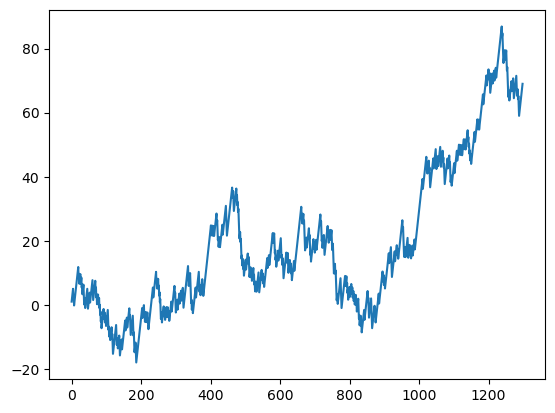

In [5]:
#Differences in dataset
def cumular(inputs):
    differentials = []
    tot = 0
    for i in range(len(inputs) - 1):
        tot += inputs[i]
        differentials.append(tot)
    return differentials

input_data = cumular(data)

plt.plot(input_data)

In [6]:
input_data = np.array(input_data)
input_data = input_data/np.max(input_data)
input_data = input_data.reshape(1299, 1)
input_data.shape 

(1299, 1)

In [123]:
train_data, test_data = input_data[:1000], input_data[1000:]

In [126]:
#Generate noise to give model a kind of Brownian motion dynamic

#We assume that given a prediction y_n, the next prediction y_n+1 is going to be a random value along some interval
#the average of which is the ground truth data... we can then use an array of possible values as training data
#to predict the ground truth of unseen time series data in the future!
import random
def gaussian_noise(value, num_noise_pts,sigma=random.uniform(0,1)):
    #sigma = random.uniform(0, 1) #In case we want a volatile variance/std
    return np.random.normal(value, 0.1,(num_noise_pts, value.shape[0])) #standard deviation can be obtained more accu 
# value = u_data[1]                 #by finding covariance matrix of dataset through
value = input_data[1]                                                         #Gaussian process regression techniques.
#Treat the value of interest as the mean of a Gaussian distribution to add stochasticity to the model
noise = gaussian_noise(value, 100)
# value.shape, train_data[1].shape
noise.shape, value.shape, noise.shape, np.mean(noise), input_data[1]
noise

array([[ 0.17059874],
       [ 0.10004593],
       [ 0.17847332],
       [ 0.00348691],
       [ 0.09765992],
       [-0.00780491],
       [-0.07041146],
       [-0.15104609],
       [-0.01763639],
       [ 0.13753316],
       [-0.10740682],
       [ 0.1049403 ],
       [-0.01921476],
       [-0.02356238],
       [-0.06141624],
       [-0.03399557],
       [ 0.07692185],
       [-0.08625811],
       [ 0.0579909 ],
       [ 0.00500339],
       [ 0.10214099],
       [-0.03063383],
       [-0.0426884 ],
       [ 0.15214787],
       [-0.09263473],
       [ 0.12558597],
       [ 0.16691889],
       [ 0.04981374],
       [ 0.09336597],
       [ 0.16409508],
       [ 0.17885539],
       [ 0.17128717],
       [ 0.03007219],
       [ 0.04900304],
       [ 0.17195511],
       [-0.1022417 ],
       [-0.11937707],
       [ 0.06563021],
       [ 0.06416929],
       [ 0.07051669],
       [ 0.08372606],
       [ 0.00882633],
       [ 0.01238951],
       [-0.21647449],
       [-0.10994196],
       [-0

[]

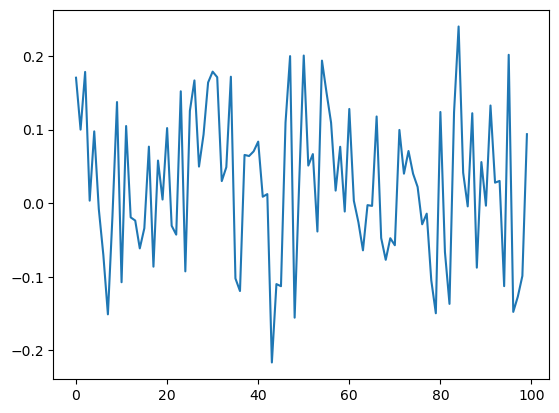

In [127]:
#Sample plot of gaussian noise
plt.plot(noise)
plt.plot()

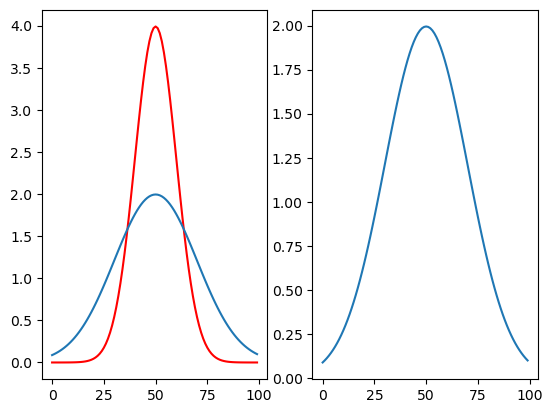

In [162]:
def gaussian_distribution_function(x, mean, sigma):
    normalization_constant = 1/(np.sqrt(2 * np.pi) * sigma)
    return normalization_constant * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

Z = np.linspace(0, 0.99, 100)
#Play around with the variance to see how much of the data is encapsulated near the mean based on 
#its 
fig, ax = plt.subplots(1,2)
low_sigma = gaussian_distribution_function(Z, 0.5, 0.1)
high_sigma = gaussian_distribution_function(Z, 0.5, 0.2)

ax[0].plot(low_sigma, color='red')
ax[0].plot(high_sigma)
ax[1].plot(high_sigma)
#A side-by-side comparison of Gaussians used for augmenting the training data

In [163]:
def preprocess(data_, num_noise_pts):
    X_, y_ = [], []
    for i in range(1,len(data_)):
        X_.append(gaussian_noise(data_[i-1], num_noise_pts, sigma=0.2))
        y_.append(data_[i])
    X_, y_ = np.array(X_), np.array(y_)
    return X_, y_

X, y = preprocess(input_data, 100, )
X = X/np.max(X)
y = y/np.max(y)
X.shape, y.shape

((1298, 100, 1), (1298, 1))

In [164]:
X_train, y_train = X[:1000], y[:1000]
X_test, y_test = X[1000:], y[1000:]

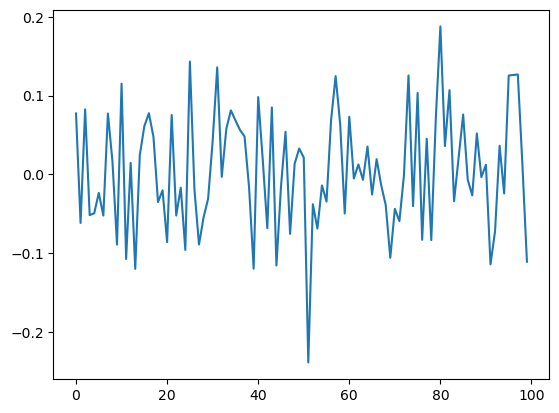

In [165]:
plt.plot(X_train[1])

In [16]:
X_test.shape, X_train.shape

((298, 100, 1), (1000, 100, 1))

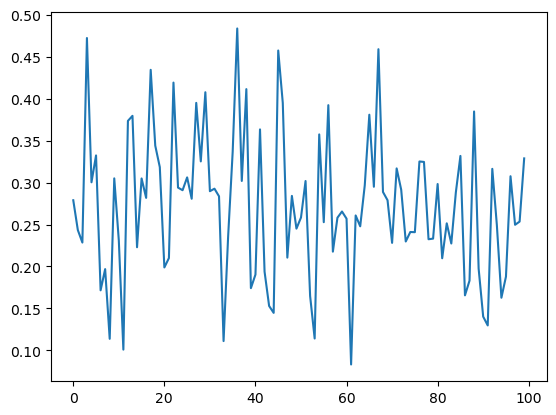

In [17]:
plt.plot(X_test[1])

In [18]:
np.max(X_train), np.max(X_test)

(0.6222490559791566, 1.0)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 100, 1), (1000, 1), (298, 100, 1), (298, 1))

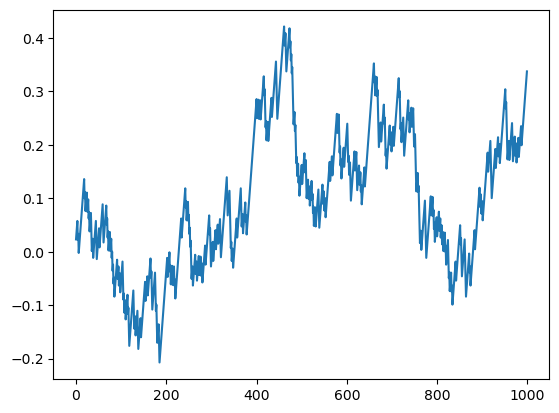

In [20]:
plt.plot(y_train)

In [21]:
X_test.shape, X_train.shape, y_train.shape

((298, 100, 1), (1000, 100, 1), (1000, 1))

In [22]:
X_train.shape

(1000, 100, 1)

In [23]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True,input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dropout(0.2))
model.add(Dense(1))

2023-09-29 23:11:21.291434: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-29 23:11:21.291920: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-29 23:11:21.291975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dolan-VivoBook-ASUSLaptop-X509DAP-M509DA): /proc/driver/nvidia/version does not exist
2023-09-29 23:11:21.293411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [151]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 150)          150600    
                                                                 
 dropout_1 (Dropout)         (None, 100, 150)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 150)          180600    
                                                                 
 dropout_2 (Dropout)         (None, 100, 150)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 150)          1

In [158]:
# history = model.fit(X_train,
#                  y_train,
#                  epochs = 10, 
#                  batch_size = 32,
#                  validation_data = (X_test, y_test),
#  )

# model.save(os.getcwd() + '/StochasticLSTM.h5')
import os
model = keras.models.load_model(os.getcwd() + '/StochasticLSTM.h5')

In [159]:
predictions = model.predict(X_test)
predict_on_train = model.predict(X_train)

32/32 [==============================] - 9s 280ms/step


In [161]:
X_train.shape, X_test.shape, y_test.shape

((1000, 100, 1), (298, 100, 1), (0,))

# FINDINGS 

###  REGULARIZATION AND FEATURE ENGINEERING:
### It seems that by doubling the standard deviation of our Gaussians from 0.1 to 0.2 in our training data,  (i.e. generating wider distributions with a more uniform probability density) the model trained actually almost perfectly fit to the test data after only 10 epochs training in this case!

### OVERFITTING AND MODEL HETEROSCEDASTICITY
### In the below plots, we compare the training data representing the first thousand datapoints in the timeseries dataset with the following 298 entries of validation data, each with the respective predictions made. Although we can see from the near-identical fit that the predictions have to the training data that the model has noticeable overfitting, it is clear from the graph on  the right that the model is not far off from making correct keypress predictions for the validation dataset.

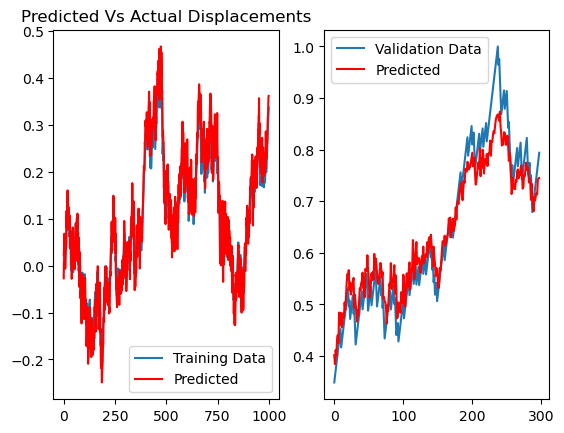

In [174]:
Z = np.linspace(0, len(y_test)-1, len(y_test))
y_test /= np.max(y_test)

plt.subplot(1,2,1)
W = np.linspace(0, len(y_train)-1, len(y_train))
plt.plot(W, y_train, label='Training Data')
plt.plot(W, predict_on_train,color='red', label='Predicted')

plt.legend()

plt.title('Predicted Vs Actual Displacements')

plt.subplot(1, 2, 2)
plt.plot(Z, y_test, label='Validation Data')
plt.plot(Z, predictions, color='red', label='Predicted')
plt.legend()

plt.show()

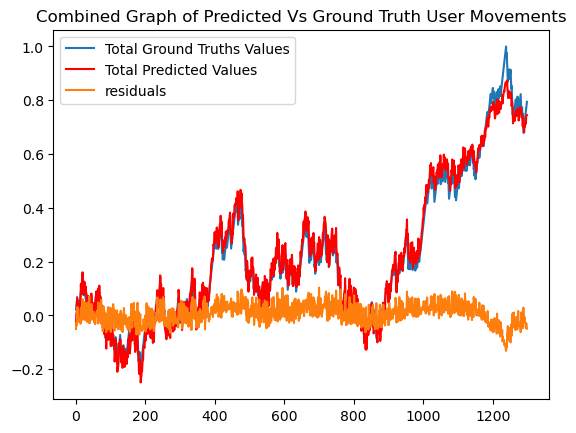

In [175]:
V = np.linspace(0, len(input_data)-1, len(input_data))

total_ground_truth = y_train.tolist() + y_test.tolist()
total_predictions = predict_on_train.tolist() + predictions.tolist()

plt.plot(V[1:], total_ground_truth, label='Total Ground Truths Values')
plt.plot(V[1:], total_predictions, color='red', label='Total Predicted Values')
plt.title('Combined Graph of Predicted Vs Ground Truth User Movements')


### Get residuals 
#Retrieve numpy representations to quickly find error residuals
residuals = np.array(total_predictions) - np.array(total_ground_truth)
plt.plot(V[1:],residuals, label='residuals')

plt.legend()

plt.show()
#Training a recurrent neural network on past data plus noise guarantees some interesting accuracy...

In [176]:
#Above, it can be seen that towards that 1100+ element of the 1298 displacement data, 
#the residuals which have appeared relatively stable appear to take a dive as the model 
#begins predicting on test data.

#This is evidence not simply of overfitting, but of the heteroscedasticity of the data used in the
#first place. Therefore, this cannot be modelled using linear regression based models, so the most 
#optimal model for this problem is a time-series model such as LSTM.

0.03581202099564855

### Below, we compare the training and validation loss curves and notice significant overfitting throughout most training epochs. A trend towards bias-variance tradeoff is apparent over time as the two functions appear to be convergent.

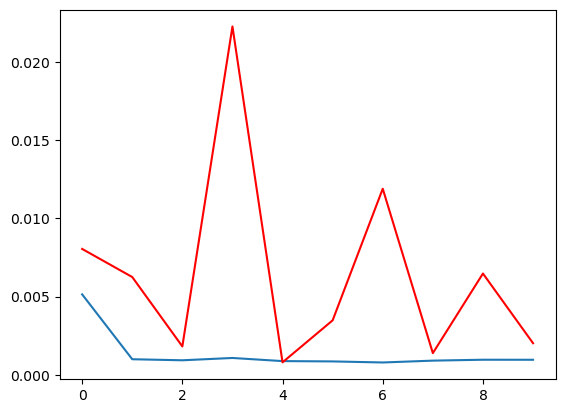

In [74]:
m = len(history.history['loss'])
M = np.linspace(0, m-1, m)
plt.plot(M, history.history['loss'])
plt.plot(M, history.history['val_loss'], color='red')

0.48183640601402955 0.07520433513352406


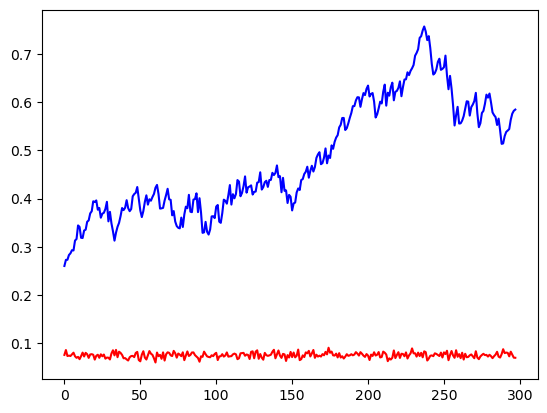

In [76]:
means, variances = [], []

for j in range(len(X_test)):
    means.append(np.mean(X_test[j]))
    variances.append(np.std(X_test[j]))
print(np.mean(means), np.mean(variances))
plt.plot(means, color='blue')
plt.plot(variances, color='red')
print()
#This means that we could model the mean of every point in the dataset as a random variable
#itself. This gives us a way of modelling additional training data as a function of time 

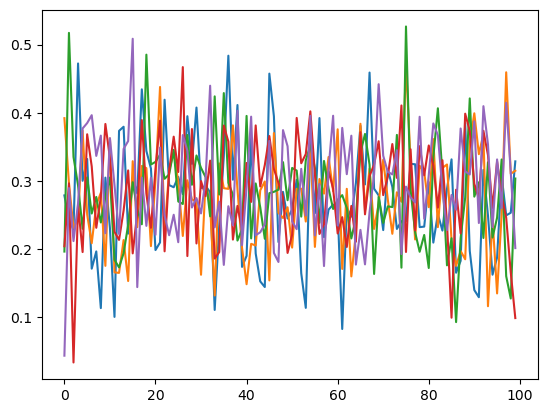

In [77]:
plt.plot(X_test[1])
plt.plot(X_test[2])
plt.plot(X_test[3])
plt.plot(X_test[4])
plt.plot(X_test[5])

### RESULTS 

### In production, the model was able to predict well on user driving patterns which it had never seen before, often anywhere from several seconds up-to half a minute. Even when trained on synthetic data, the recurrent LSTM is able to make predictions on the new data with incredible accuracy.

### Conclusions

### It has been demonstrated that a small amount user keyboard input data spanning a few minutes of gameplay is sufficient to train a recurrent LSTM model that can accurately mimic user typing biometrics off of gameplay alone. This was achieved using data augmentation to create a multiple copies of the original time-series data with Gaussian noise added. It was further found that the effect of the noise augmentation on model training was optimized for Gaussians with a Standard Deviation of Sigma=0.2.

### This likely indicates that a slightly wider distribution is better for model regularization, most likely because it provides a wider selection of augmented training and validation data. It's trivial to see why this helps it generalize better. 

### How the AutopilotAI could be Improved

# 1). Use a Transformer Architecture 
### Were I to do this project again, I would replace the architecture with a less computationally expensive algorithm than LSTM. Indeed, the Transformer architecture proposed int the *Attention Is All You Need* paper enables parallel computation of predictions through a self-attention mechanism. Transformers are found to be exponentially faster at training on time-serious tasks, and have a longer window of attention than LSTM's (Notice, the model here exhibits significant heteroscedasticity- the variance in error residuals, particularly in the validation dataset, appears to widen slightly over time. Transformers can visibly reduce this phenomenon, however likely can't completely remove it since the data is inherently nonlinear).

### The Transformer in question likely would be a decoder only model, which takes in past keypresses as training data, passes it through several decoder layers with a causal self-attention mask and feedforward layers, and predicts the next button press correctly. This might allow it to predict on all four direction keys (W, A, S, D) in gameplay rather than the LSTM which in this example is optimal for a single direction (predicting on W/A or S/D). 

# 2). Include Image Data 

### Another benefit to the performance boost of using a Transformer is that it would be easier to train the AI on image data. Given the potential complexity of such a model, it may not be necessary to strictly train it on timeseries predictions as we did the LSTM example. 

### The image data could be fed through a stack of convolutional layers, sent through a Transformer Encoder Stack, while the aforementioned user keypress data is fed into the Decoder, with a Cross-Attention layer in the Decoder Layers providing an interface for image and keypress data inside the model. It would then successfully be able to predict each keystroke as a function  both of previous keystrokes, but also of the screen image context from in-the-game. This architecture would be exactly the same as the original  *Attention Is All You Need*  paper, and as is the case with GPT models could be pre-trained, open-sourced, and fine-tuned by other ML-Engineers. 



### ETHICAL CONCERNS 

### If anybody takes serious interest in pursuing this research much further, then cheating in online games will become increasingly more formidable. While this implementation is harmless and mildly useful, the aforementioned Transformer based strategy is highly generalizeable to online racing and shooters. The potential for online fraud is very high should gaming communities get a sweet-tooth for AI cheats like this.